# Check location of minimum surface pressure in simulations with different resolution and remapping

Original script written by Georgios Papavasileiou 

Modified by Ting-Chen Chen (ting-chen.chen@kit.edu) 

Added the re-centering of the domain

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.ndimage
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import psutil
import datetime
import time as tm
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")

In [2]:
import xarray as xr

## Load data for maps and track data

In [44]:
def load_data_and_path(exp, # in vars
                   dt,
                   data_res,
                   p2level,
                   path_data,
                   path_track,
                  dat, # inout vars
                  dur,
                  lat,
                  lon,
                pmin):

    exp_str = exp+'_'+data_res
    
    if   dt == 1:
         data_dt = '1hrly'
    elif dt == 6:
         data_dt = '6hrly'
            
    data_file = "PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(p2level))+"hPa.nc"
    
    # load data
    ds = xr.open_dataset(path_data+data_file)
    dat[exp_str] = ds
    
    # load track
    df_track = pd.read_csv(path_track+'Track_for_'+exp+'_'+str(dt)+'hrly_'+data_res+'.csv')
    dur[exp_str] = df_track['time']
    lon[exp_str]  = df_track['lon']
    lat[exp_str]  = df_track['lat']
    pmin[exp_str]  = df_track['pmin']
    
    return dat, dur, lat, lon, pmin

In [45]:
exp = {
    1: 'channel_80km_0005',
    2: 'channel_2km_0005',
    3: 'channel_2km_0005'
}

In [46]:
data_res = {
    1: '1x1latlon',
    2: '1x1latlon',
    3: '025x025latlon'
}

In [47]:
TC_work = '/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/PTE/'
# this is indicated here specifically for the 0.25 latlon remap
CB_scratch = '/scratch/b/b380782/check_remapping_on_PTE/'+exp[3]+'/PTE_out/'

In [48]:
path_data = {
    1: TC_work+'/maps/',
    2: TC_work+'/maps/',
    3: CB_scratch+'/maps/'
}

In [49]:
path_track = {
    1: TC_work+'cyclone_tracks/',
    2: TC_work+'cyclone_tracks/',
    3: CB_scratch+'cyclone_tracks/'
}

In [50]:
dt = 6
p2level=50

In [51]:
# initialize dicts for data and track paths
dat = {}
dur = {}
lon = {}
lat = {}
pmin = {}

# dict to handle data
datname = {}

for i in range(1,4):

    datname[i] = exp[i]+'_'+data_res[i]

    dat, dur, lat, lon, pmin = load_data_and_path(exp[i],
                   dt,
                   data_res[i],
                   p2level,
                   path_data[i],
                   path_track[i],
                  dat,
                  dur,
                  lat,
                  lon,
                                                 pmin)

# Prep for plotting

In [53]:
# set timestep for day 4
itimestep = 12

day = dur[datname[1]][itimestep]
day

3.0

In [54]:
# get location of pmin at spec timestep
lon_min = {}
lat_min = {}

for i in range(1,4):
    lon_min[datname[i]] = lon[datname[i]][itimestep]
    lat_min[datname[i]] = lat[datname[i]][itimestep]

# set boxsize for plotting
boxsize = 30

### Roll the data to left or right if necessary

In [55]:
rolled_eward = {}
rolled_wward = {}

# roll data in case pmin is close to periodic boundary
for i in range(1,4):
    to_roll_min = dat[datname[i]]['lon'].min().values - (lon_min[datname[i]]-boxsize/2)
    to_roll_max = dat[datname[i]]['lon'].max().values - (lon_min[datname[i]]+boxsize/2)
    if to_roll_min>0:
        # determine positions to roll assuming regular grid spacing
        dlon = dat[datname[i]]['lon'][1]-dat[datname[i]]['lon'][0]
        to_roll = int(boxsize/(2*dlon))

        dat[datname[i]] = dat[datname[i]].roll(lon=to_roll)
        
        rolled_eward[datname[i]] = boxsize/2
        rolled_wward[datname[i]] = 0.
    elif to_roll_max<0:
        dlon = dat[datname[i]]['lon'][1]-dat[datname[i]]['lon'][0]
        to_roll = int(boxsize/(2*dlon))
        
        dat[datname[i]] = dat[datname[i]].roll(lon=-to_roll)
        
        rolled_wward[datname[i]] = -boxsize/2
        rolled_eward[datname[i]] = 0.
    else:
        rolled_eward[datname[i]] = 0.
        rolled_wward[datname[i]] = 0.

In [56]:
lon_min

{'channel_80km_0005_1x1latlon': 18.5,
 'channel_2km_0005_1x1latlon': 13.5,
 'channel_2km_0005_025x025latlon': 18.5}

In [57]:
rolled_eward

{'channel_80km_0005_1x1latlon': 15.0,
 'channel_2km_0005_1x1latlon': 15.0,
 'channel_2km_0005_025x025latlon': 15.0}

In [58]:
rolled_wward

{'channel_80km_0005_1x1latlon': 0.0,
 'channel_2km_0005_1x1latlon': 0.0,
 'channel_2km_0005_025x025latlon': 0.0}

In [59]:
for i in range(1,4):
    lon_min[datname[i]] += rolled_eward[datname[i]]
    lon_min[datname[i]] += rolled_wward[datname[i]]

# Plotting

!! Attention: pcolormesh may be used in a way here, that prevents plotting the last column of the data. Double-check if planning to use this figs somewhere.

Text(0.5, 1.0, 'Day 4.0')

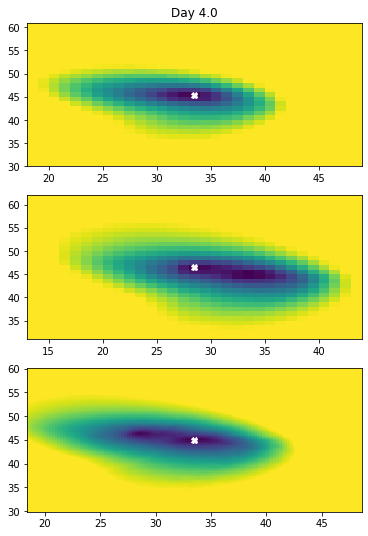

In [60]:
vmin=0
vmax=2000

fig, ax = plt.subplots(3, 1, figsize=(6,9))

for i in range(1,4):
    ax[i-1].pcolormesh(dat[datname[i]]['lon'].sel(lon=slice(lon_min[datname[i]]-boxsize/2,lon_min[datname[i]]+boxsize/2)),
                       dat[datname[i]]['lat'].sel(lat=slice(lat_min[datname[i]]-boxsize/2,lat_min[datname[i]]+boxsize/2)),
                       dat[datname[i]]['mslp'].sel(time=day,
                            lat=slice(lat_min[datname[i]]-boxsize/2,lat_min[datname[i]]+boxsize/2),
                            lon=slice(lon_min[datname[i]]-boxsize/2,lon_min[datname[i]]+boxsize/2))
 -dat[datname[i]]['mslp'].sel(time=day).min(),
                      vmin=vmin,
                      vmax=vmax)
    ax[i-1].plot(lon_min[datname[i]],lat_min[datname[i]],marker='X',color='white')
    
ax[0].set_title('Day '+str(day+1))

#### 